# Stock price prediction

In this case study we use various supervised learning-based models to predict the stock price of Microsoft using correlated assets and its own historical data.

## 1. Problem definition

Predicted variable: Weekly return of the Microsoft stock

Historical data of Microsoft and potentially correlated assets are used:
* Stocks: Microsoft (MSFT), IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

Following models are implemented:
* Linear Regression
* Lasso
* Elastic Net
* KNN
* Decision Tree (CART)
* Support Vector Machine
* Ada Boost
* Gradient Boosting Method
* Random Forest
* Extra Trees
* Neural Network - Shallow - Using sklearn
* Deep Neural Network - Using Keras
* ARIMA Model
* LSTM - Using Keras



## 2. Load libraries and dataset

In [222]:
# Libraries for data acquisition and visualization
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

# Libraries for supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Libraries for DL models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for time series models
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [223]:
# Load data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [224]:
stk_data.head()

Attributes Adj Close                   Close                    High           \
Symbols         MSFT      IBM   GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   
Date                                                                            
2017-03-08    60.667  135.841  853.64  64.99  171.558  853.64  65.08  172.992   
2017-03-09    60.424  134.122  857.84  64.73  169.388  857.84  65.20  171.367   
2017-03-10    60.611  134.614  861.41  64.93  170.010  861.41  65.26  171.597   
2017-03-13    60.406  133.577  864.58  64.71  168.700  864.58  65.19  170.229   
2017-03-14    60.126  133.017  865.91  64.41  167.992  865.91  64.55  169.044   

Attributes            Low                    Open                      Volume  \
Symbols      GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   GOOGL       MSFT   
Date                                                                            
2017-03-08  856.93  64.25  171.415  851.25  64.26  172.801  853.12  2.151e+07   
2017-03-09  860.71  64.48  168.145  852.67  65.19  171.272  853.69  1.985e+07   
2017-03-10  864.23  64.75  169.618  857.61  65.11  170.373  862.70  1.954e+07   
2017-03-13  867.13  64.57  168.662  860.82  65.01  170.029  860.83  2.010e+07   
2017-03-14  867.58  64.15  167.505  860.13  64.53  168.432  863.75  1.428e+07   

Attributes                        
Symbols           IBM      GOOGL  
Date                              
2017-03-08  3.721e+06  1.029e+06  
2017-03-09  5.695e+06  1.348e+06  
2017-03-10  3.243e+06  1.337e+06  
2017-03-13  3.642e+06  1.167e+06  
2017-03-14  3.292e+06  1.062e+06

In [225]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-03-09,114.71,1.217
2017-03-10,115.02,1.216
2017-03-13,114.61,1.223
2017-03-14,114.63,1.217
2017-03-15,114.66,1.222


In [226]:
idx_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-03-09,2364.87,20858.19,12.30
2017-03-10,2372.60,20902.98,11.66
2017-03-13,2373.47,20881.48,11.35
2017-03-14,2365.45,20837.37,12.30
2017-03-15,2385.26,20950.10,11.63


In [227]:
# 5 business days in a week
return_period = 5

In [228]:
# Y = MSFT future returns
Y = np.log(stk_data.loc[:'2021', ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period) 
Y.name = Y.name[-1]+'_pred'
Y.describe()

count    1210.000
mean        0.007
std         0.031
min        -0.179
25%        -0.009
50%         0.009
75%         0.026
max         0.164
Name: MSFT_pred, dtype: float64

In [229]:
X1 = np.log(stk_data.loc[:'2021', ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data[:'2021']).diff(return_period)
X3 = np.log(idx_data[:'2021']).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:'2021', ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-03-08 to 2021-12-31
Freq: B
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GOOGL      1210 non-null   float64
 1   IBM        1210 non-null   float64
 2   DEXJPUS    1149 non-null   float64
 3   DEXUSUK    1149 non-null   float64
 4   SP500      1170 non-null   float64
 5   DJIA       1170 non-null   float64
 6   VIXCLS     1170 non-null   float64
 7   MSFT_DT    1155 non-null   float64
 8   MSFT_3DT   1155 non-null   float64
 9   MSFT_6DT   1155 non-null   float64
 10  MSFT_12DT  1155 non-null   float64
dtypes: float64(11)
memory usage: 117.9 KB


In [230]:
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2017-06-02 to 2021-12-22
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  217 non-null    float64
 1   GOOGL      217 non-null    float64
 2   IBM        217 non-null    float64
 3   DEXJPUS    217 non-null    float64
 4   DEXUSUK    217 non-null    float64
 5   SP500      217 non-null    float64
 6   DJIA       217 non-null    float64
 7   VIXCLS     217 non-null    float64
 8   MSFT_DT    217 non-null    float64
 9   MSFT_3DT   217 non-null    float64
 10  MSFT_6DT   217 non-null    float64
 11  MSFT_12DT  217 non-null    float64
dtypes: float64(12)
memory usage: 22.0 KB


In [231]:
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

## 3. Exploratory data analysis
### 3.1 Descriptive statistics

In [232]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,217.000,217.000,2.170e+02,2.170e+02,2.170e+02,217.000,217.000,217.000,217.000,217.000,217.000,217.000
mean,0.007,0.005,3.173e-04,3.174e-04,-2.554e-04,0.003,0.002,-0.003,0.007,0.021,0.044,0.087
std,0.028,0.034,3.523e-02,9.561e-03,1.262e-02,0.022,0.024,0.160,0.030,0.048,0.059,0.068
min,-0.120,-0.131,-1.569e-01,-3.572e-02,-7.346e-02,-0.131,-0.164,-0.447,-0.120,-0.149,-0.238,-0.116
25%,-0.010,-0.012,-1.710e-02,-4.576e-03,-7.339e-03,-0.004,-0.006,-0.090,-0.011,-0.005,0.011,0.043
50%,0.011,0.008,2.138e-03,5.388e-04,-5.560e-04,0.004,0.003,-0.020,0.011,0.026,0.047,0.087
75%,0.024,0.026,1.918e-02,5.477e-03,8.839e-03,0.013,0.012,0.064,0.025,0.049,0.082,0.131
max,0.077,0.089,9.203e-02,3.683e-02,5.530e-02,0.059,0.079,0.992,0.077,0.147,0.244,0.306


In [233]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-06-02,-0.020,0.004,-0.008,-0.007,7.009e-03,0.010,0.006,-0.006,0.030,0.053,0.097,0.105
2017-06-12,0.016,-0.043,0.018,-0.007,-2.025e-02,-0.003,0.002,0.129,-0.035,0.030,0.025,0.082
2017-06-19,-0.005,0.014,-0.002,0.015,6.693e-03,0.010,0.014,-0.100,0.016,0.013,0.032,0.094
2017-06-26,-0.034,-0.003,0.003,0.001,-8.636e-04,-0.006,-0.006,-0.046,-0.005,-0.025,0.037,0.077
2017-07-03,0.026,-0.056,0.002,0.016,1.705e-02,-0.004,0.003,0.125,-0.034,-0.023,0.007,0.042


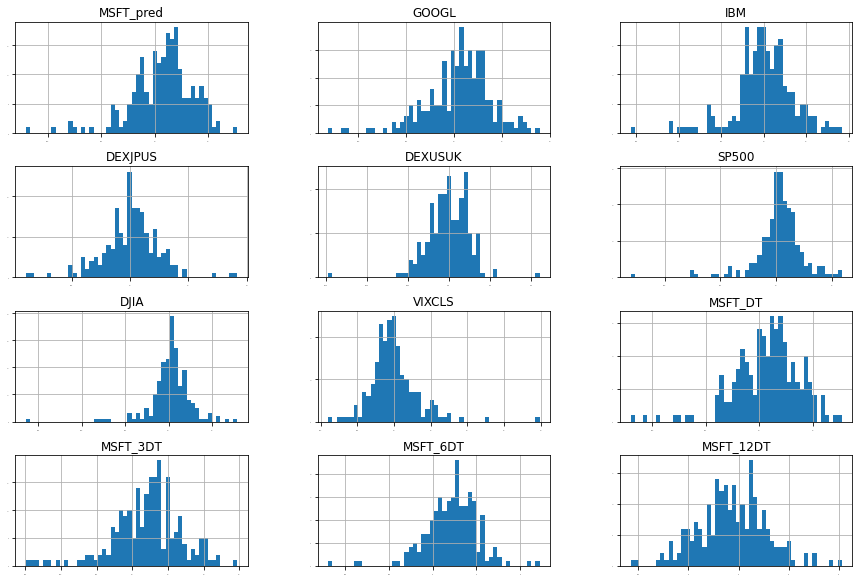

In [234]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15, 10))
pyplot.show()

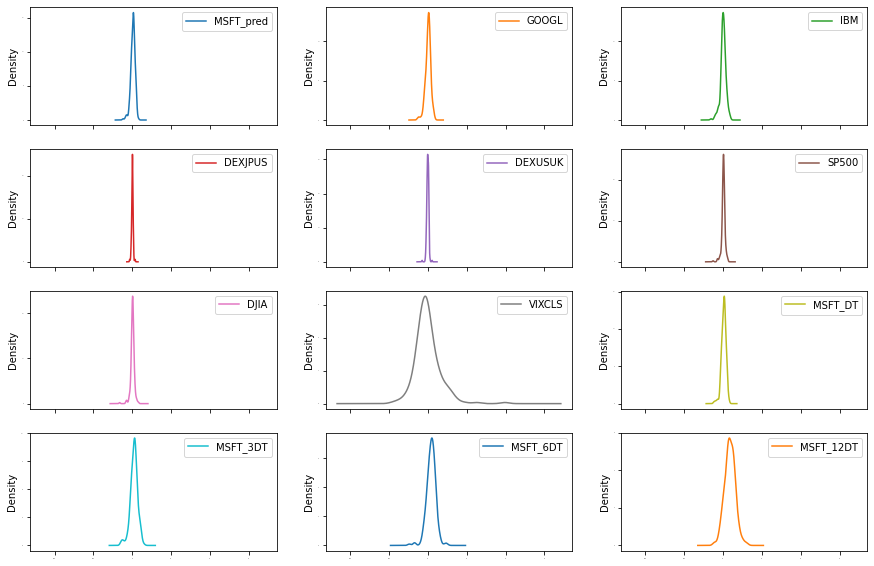

In [235]:
dataset.plot(kind='density', subplots=True, layout=(4, 3), sharex=True, fontsize=1, legend=True, figsize=(15,10))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

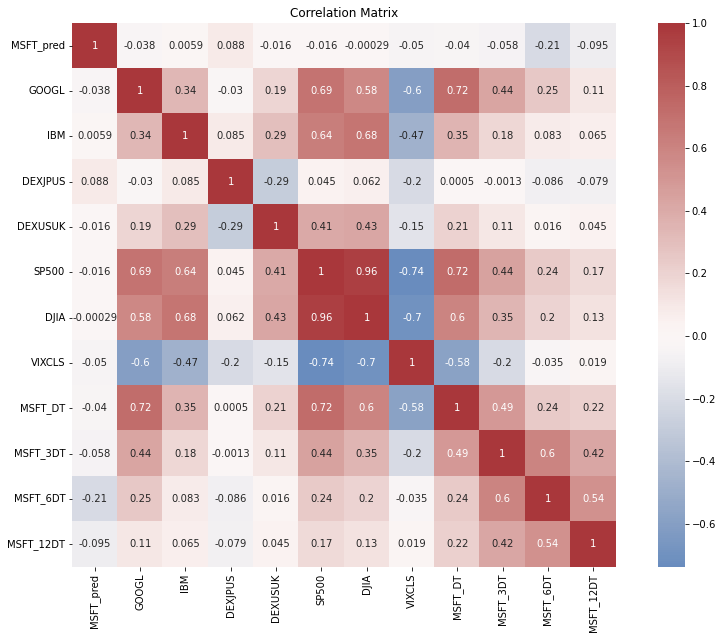

In [236]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='vlag', center=0)

<Figure size 1080x1080 with 0 Axes>

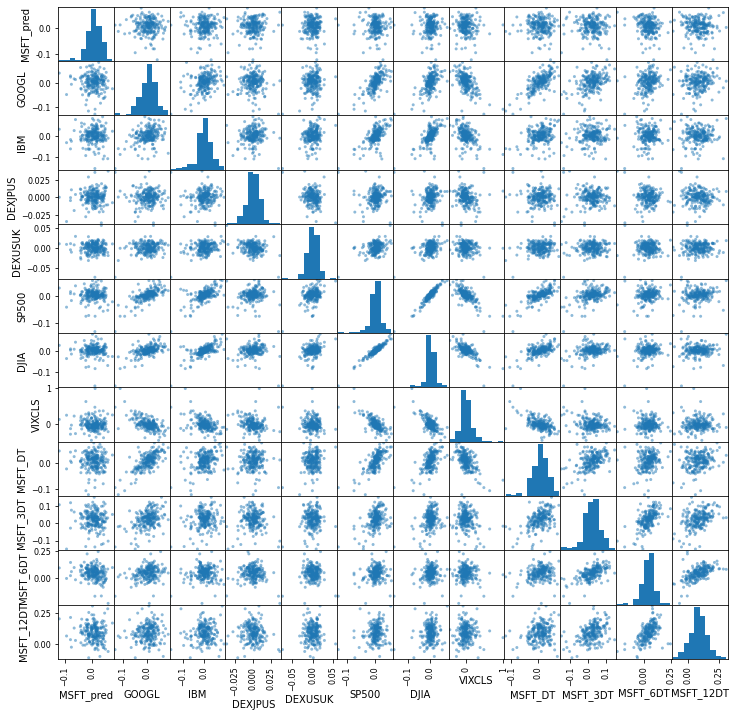

In [237]:
pyplot.figure(figsize=(15,15))
pd.plotting.scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

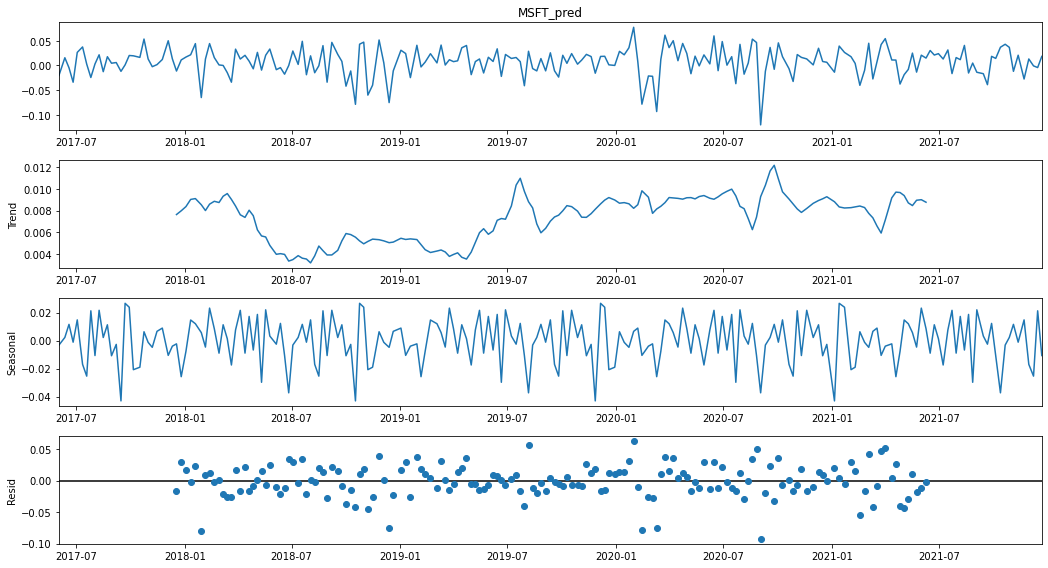

In [238]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

## 4. Data preparation

### 4.1 Feature selection

In [239]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(11,'Score').set_index('Specs')   # Print 11 best features

,Score
Specs,
MSFT_6DT,9.547e+00
MSFT_12DT,1.969e+00
DEXJPUS,1.676e+00
MSFT_3DT,7.257e-01
VIXCLS,5.450e-01
MSFT_DT,3.415e-01
GOOGL,3.180e-01
SP500,5.751e-02
DEXUSUK,5.557e-02


## 5. Evaluate algorithms and models
### 5.1 Train test split and evaluation metrics

In [240]:
validation_size = 0.2

#Select an arbitrary split point in the ordered list of observations and creat two new datasets.
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### 5.2 Test options and evaluation metrics

In [241]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

### 5.3 Compare models and algorithm
#### 5.3.1 Machine learning models from scikit-learn

In [242]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural network algorithm
models.append(('MLP', MLPRegressor()))

# Ensemble models - Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Ensemble models - Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [243]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    # K fold analysis
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # Converted mean square error to positive. 
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000958 (0.000482) 0.000814 0.000568
LASSO: 0.000870 (0.000443) 0.000863 0.000568
EN: 0.000870 (0.000443) 0.000863 0.000568
KNN: 0.001026 (0.000518) 0.000690 0.000612
CART: 0.002093 (0.000691) 0.000000 0.001586
SVR: 0.001653 (0.000404) 0.001700 0.001431
MLP: 0.002229 (0.001028) 0.002651 0.002581
ABR: 0.000998 (0.000394) 0.000434 0.000682
GBR: 0.001242 (0.000554) 0.000074 0.000962
RFR: 0.001073 (0.000420) 0.000142 0.000760
ETR: 0.001036 (0.000432) 0.000000 0.000716


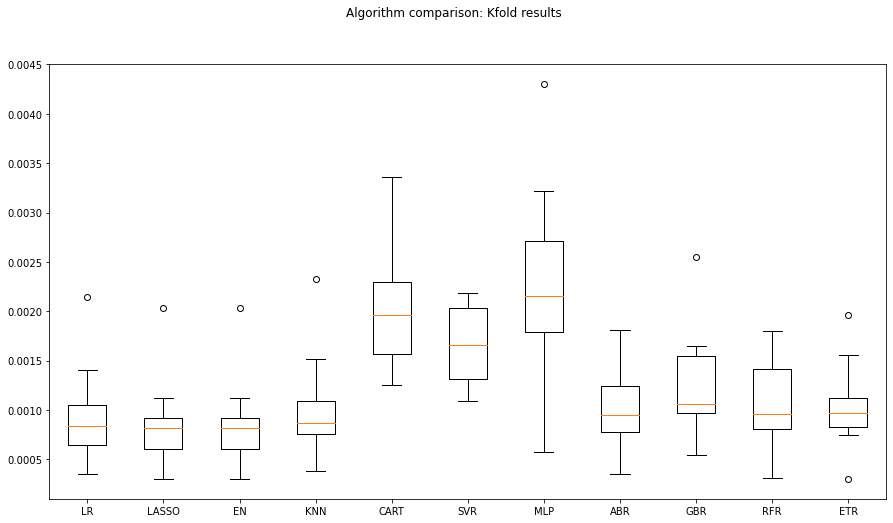

In [244]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

__K-fold results__

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

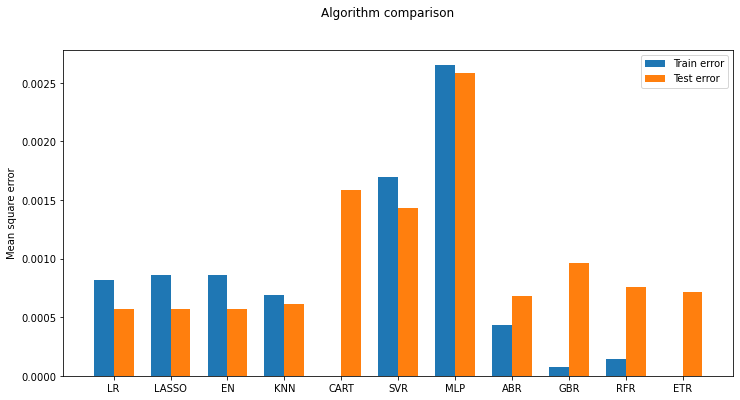

In [245]:
# Compare algorithms
fig  = pyplot.figure()

ind = np.arange(len(names))    #the x locations for the groups
width = 0.35    #the width of the bars

fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test error')
fig.set_size_inches(12, 6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean square error')
pyplot.show()

__Training and test errors__

We still see a better performance of the linear models. 
Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. 
Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. 
We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

#### 5.3.2 Time series based models - ARIMA and LSTM

__ARIMA model__

Let us first prepare the dataset for ARIMA models, by having only the correlated varriables as exogenous variables.

In [246]:
X_train_ARIMA = X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA = X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

In [247]:
Y_train.index = Y_train.index.to_period('D')
X_train_ARIMA.index = X_train_ARIMA.index.to_period('D')
X_test_ARIMA.index = X_test_ARIMA.index.to_period('D')

In [248]:
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1,0,0))
model_fit = modelARIMA.fit()

In [249]:
error_training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len-1, end=to_len-1, exog=X_test_ARIMA)[1:]
error_test_ARIMA = mean_squared_error(Y_test, predicted) 
error_test_ARIMA

0.0006158164419734131

__LSTM model__

In [250]:
seq_len = 2     # Length of the sequence for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [251]:
# LSTM network
def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0):
    # Create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    # More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model

LSTMmodel = create_LSTMmodel(12, learn_rate=0.01, momentum=0)
LSTMmodel_fit = LSTMmodel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM), epochs=10, batch_size=27, verbose=0, shuffle=False)

/Users/jkwon/opt/anaconda3/envs/test/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


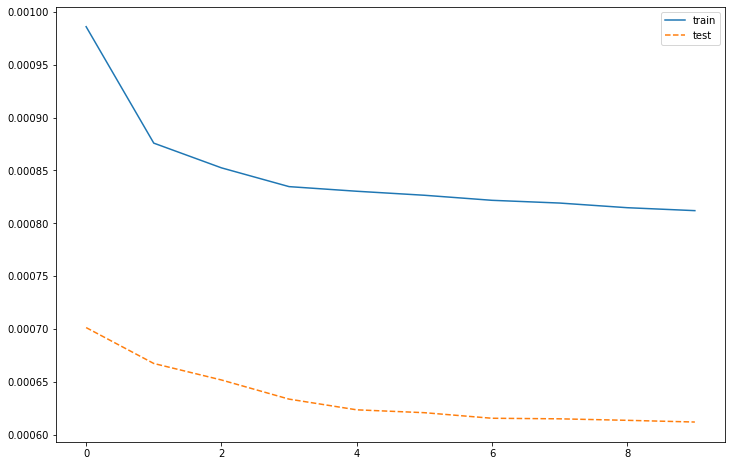

In [252]:
# Visual plot to check if the error is reducing
pyplot.plot(LSTMmodel_fit.history['loss'], label='train')
pyplot.plot(LSTMmodel_fit.history['val_loss'], '--', label='test')
pyplot.legend()
pyplot.show()

In [253]:
error_training_LSTM = mean_squared_error(Y_train_LSTM, LSTMmodel.predict(X_train_LSTM))
predicted = LSTMmodel.predict(X_test_LSTM)
error_test_LSTM = mean_squared_error(Y_test, predicted)

In [254]:
# Append to previous results
test_results.append(error_test_ARIMA)
test_results.append(error_test_LSTM)

train_results.append(error_training_ARIMA)
train_results.append(error_training_LSTM)

names.append("ARIMA")
names.append("LSTM")

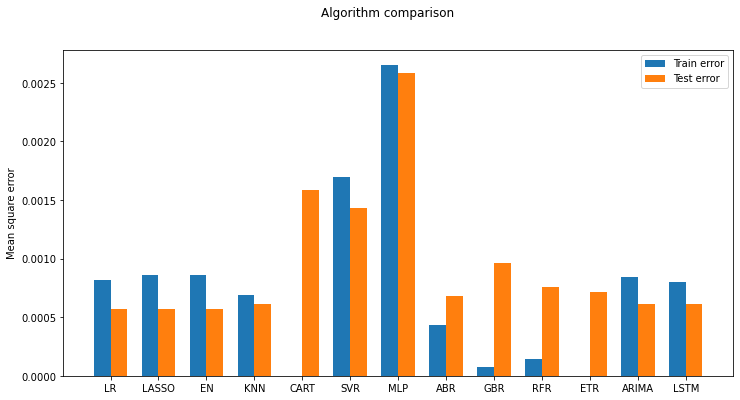

In [255]:
# Compare algorithms
fig  = pyplot.figure()

ind = np.arange(len(names))    #the x locations for the groups
width = 0.35    #the width of the bars

fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test error')
fig.set_size_inches(12, 6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean square error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA and LSTM models comparable to the linear supervised-regression models such as LR, LASSO and EN. 
This can primarily be due to the strong linear relationship as discussed before. 

We select the ARIMA model for the model tuning.

## 6. Model tuning and grid search

As shown in the chart above, the ARIMA model is one of the best model, so we perform the model tuning of the ARIMA model. 
The default order of ARIMA model is (1,0,0). 
We perform a grid search with different combination p,d and q in the ARIMA model's order.

In [267]:
# Grid search for ARIMA model
# Change p, d and q and check for the best result

# Evaluate an ARIMA model for a given order (p,d,q)
# Assuming that the train and test data is already defined before
def evaluate_arima_model(arima_order):
    modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_vlaues, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_vlaues:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

# Evaluate parameters
p_vlaues = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
evaluate_models(p_vlaues, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0008423
ARIMA(0, 0, 1) MSE=0.0008384
ARIMA(0, 1, 0) MSE=0.0014612
ARIMA(0, 1, 1) MSE=0.0008633
ARIMA(1, 0, 0) MSE=0.0008409
ARIMA(1, 0, 1) MSE=0.0008298
ARIMA(1, 1, 0) MSE=0.0013562
ARIMA(1, 1, 1) MSE=0.0009037
ARIMA(2, 0, 0) MSE=0.0008095
ARIMA(2, 0, 1) MSE=0.0008090
ARIMA(2, 1, 0) MSE=0.0011067
ARIMA(2, 1, 1) MSE=0.0008755
Best ARIMA(2, 0, 1) MSE=0.0008090


## 7. Finalise the model
### 7.1 Results on the test dataset

In [268]:
# Prepare model
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(2,0,1))
model_fit_tuned = modelARIMA_tuned.fit()

In [270]:
# Estimate accuracy on validation set
predicted_tuned = model_fit_tuned.predict(start=tr_len-1, end=to_len-1, exog=X_test_ARIMA)[1:]
print(mean_squared_error(Y_test, predicted_tuned))

0.0006459478371709788


### 7.2 Save model for later use

In [264]:
#Libraries for Saving the Model
from pickle import dump

filename = 'ch5_1_finalised_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

In [265]:
# # some time later...
# # load the model from disk
# from pickle import load
# loaded_model = load(open(filename, 'rb'))
# # estimate accuracy on validation set
# #rescaledValidationX = scaler.transform(X_validation) #in case the data is scaled.
# #predictions = model.predict(rescaledValidationX)
# predictions = model.predict(X_validation)
# result = mean_squared_error(Y_validation, predictions)
# print(result)

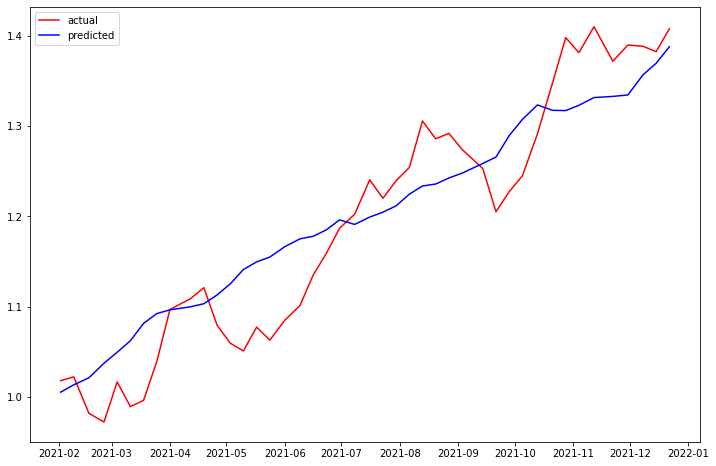

In [266]:
# Comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (12,8)
pyplot.show()

__Conclusion:__

We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and elastic net) - along with the time series model such as ARIMA are promising modeling approaches for asset price prediction problem. These models can enable financial practitioners to model time dependencies with a very flexible approach.  
We should also note that we can use better set of indicators, such as P/E ratio, trading volume, technical indicators or news data, which might lead to better results. -> To be demonstrated in further study.  
Overall, we created a supervised-regression and time series modelling framework which allows us to perform asset class prediction using historical data to generate results and analyze risk and profitability before risking any actual capital.